In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline

In [2]:
df=pd.read_csv("ts.csv",index_col=[7], parse_dates=[7])

In [3]:
df.drop(['month', 'day', 'hour','schooltimes',
       'pubHolidays', 'year'],inplace=True,axis=1)

# Checking For Stationarity

In [4]:
def check_stationarity(timeseries):
    '''
    defining  the rolling statistics
    '''
    rol_mean =  timeseries.rolling(window=30,center=False).mean()
    rol_std = timeseries.rolling(window=30,center=False).std()
    '''
    plot rolling statistics
    '''
    orig = plt.plot(timeseries, color='blue',label='Original Ts')
    mean = plt.plot(rol_mean, color='red', label='Rolling Mean')
    std = plt.plot(rol_std, color='black', label = 'Rolling Std')
    plt.xlabel('time')
    plt.ylabel('Number of calls')
    plt.legend(loc='best')
    plt.title('Rolling Mean And Standard Deviation')
    plt.show(block=False)

/home/lawrence/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


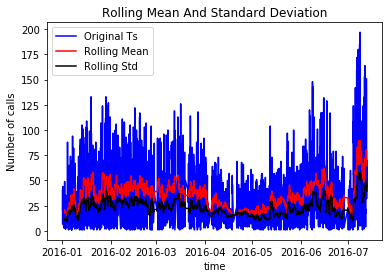

In [5]:
check_stationarity(df)

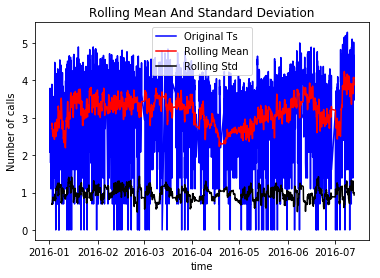

In [6]:
ts_log = np.log(df)
check_stationarity(ts_log)

# Trring To Make The TS Stationary

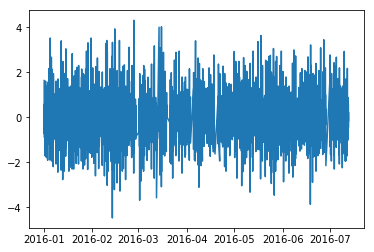

In [7]:
#1.Differencing
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)


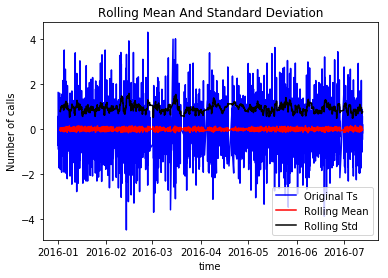

In [8]:
ts_log_diff.dropna(inplace=True)
check_stationarity(ts_log_diff)

# Splitting And Visualizing Our Data

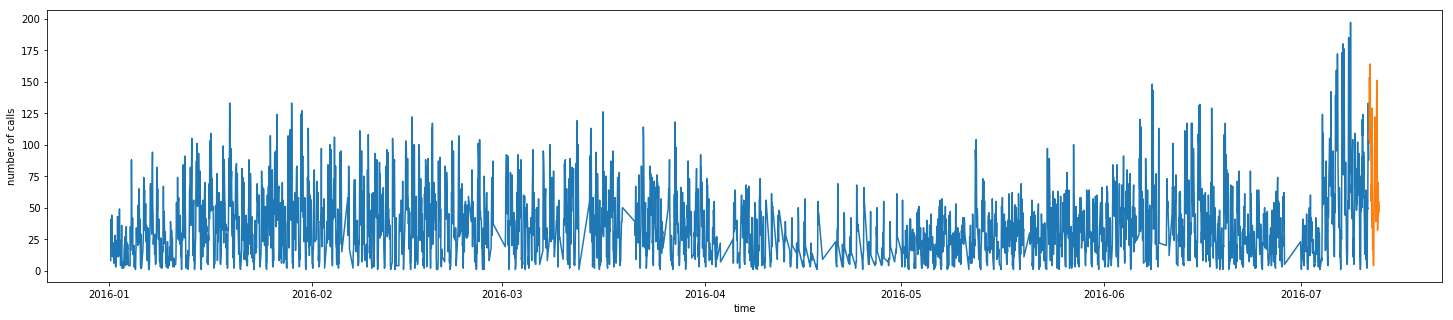

In [9]:
train=df[0:3660]
test=df[3660:3699]
plt.figure(figsize=(25,5))
plt.xlabel('time')
plt.ylabel('number of calls')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show(block=False)

# Creating TS Features

In [10]:
def create_ts_features(df):
    #creating TS features from index
   
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df[['hour','dayofweek','dayofyear','dayofmonth','weekofyear']]
    return X

In [11]:
X_train, y_train = create_ts_features(train), train['num_calls']
X_test, y_test   = create_ts_features(test), test['num_calls']

/home/lawrence/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/lawrence/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/lawrence/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

# Training XGBoost

In [12]:
reg = xgb.XGBRegressor(n_estimators=42, learning_rate=0.11, gamma=0, subsample=0.74,
                           colsample_bytree=1, max_depth=7)
reg.fit(X_train,y_train,eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50,  verbose=False)     

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.11, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=42,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.74)

# Features Of Importance From XGBOOST

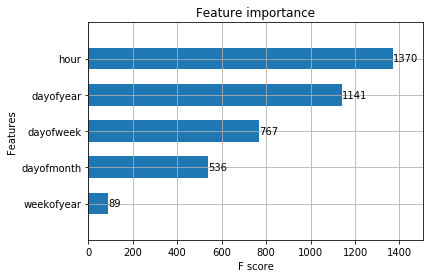

In [13]:
xgb.plot_importance(reg, height=0.6)

# Forcasting

In [14]:

def ploting_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time monthdayhour')
    plt.ylabel('Number of calls')
    plt.plot(df.index,df, label='Oroginal')
    plt.plot(X_test.index,X_test_pred, label='Prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)


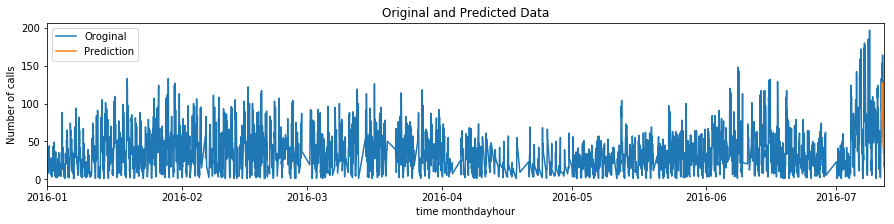

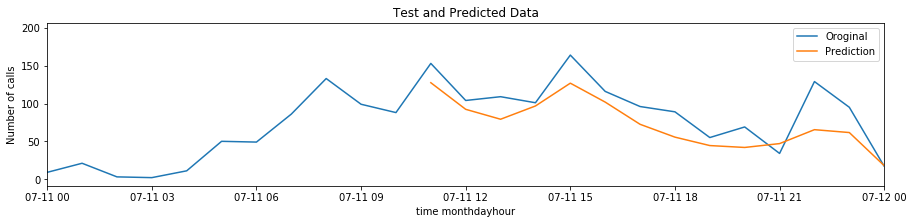

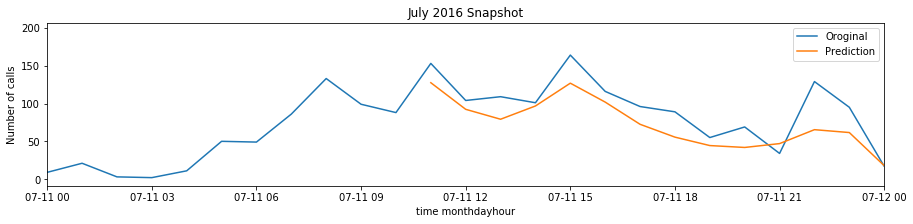

In [15]:

X_test_pred = reg.predict(X_test)
    
ploting_performance(df,df.index[0].date(),df.index[-1].date(),
                 'Original and Predicted Data')

ploting_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')

ploting_performance(y_test, '2016-07-11', '2016-07-12', 'July 2016 Snapshot')

plt.legend()

plt.show()


# Performance Evaluation

In [16]:
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

552.4841775616976

In [17]:
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)

18.465164751619906

In [18]:

def mean_absolute_percentage_error(y_true, y_pred): 
    #Calculates MAPE given y_true and y_pred
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [19]:
mean_absolute_percentage_error(y_test,X_test_pred)

32.15904789369738

In [20]:

X_test['num_calls'] = y_test
X_test['num_Prediction'] = X_test_pred
X_test['error'] = y_test - X_test_pred
X_test['abs_error'] = X_test['error'].apply(np.abs)
error_by_day = X_test.groupby(['dayofweek','hour']) \
   .mean()[['num_calls','num_Prediction','error','abs_error']]

error_by_day.sort_values('error', ascending=True).head(5)


/home/lawrence/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


num_calls  num_Prediction      error  abs_error
dayofweek hour                                                 
1         12           39       92.403610 -53.403610  53.403610
          9            64       96.292114 -32.292114  32.292114
          18           32       62.373928 -30.373928  30.373928
          10           72       97.792961 -25.792961  25.792961
          11          108      129.461197 -21.461197  21.461197

## Have A Look At Afew Best Predicted Hours From TestSet

In [21]:
error_by_day.sort_values('abs_error', ascending=True).head(5)

num_calls  num_Prediction     error  abs_error
dayofweek hour                                                
1         0            17       17.839468 -0.839468   0.839468
          3             4        6.203769 -2.203769   2.203769
          8           122      124.623222 -2.623222   2.623222
          21           44       47.390800 -3.390800   3.390800
          1            22       18.233143  3.766857   3.766857

In [22]:
##########################################################3

## Working With TestDataset For Submission

In [23]:
test=pd.read_csv("tsTest.csv",index_col=[0], parse_dates=[0])

In [24]:
test.drop(['month', 'day', 'hour', 'schooltimes',
       'pubHolidays', 'year',"time_index"],inplace=True,axis=1)

In [25]:
test=create_ts_features(test)

In [26]:
predictions= reg.predict(test)

# SubmissionFile Preparation

In [27]:
appending=pd.read_csv("submission.csv",header=None)

In [28]:
submission = pd.DataFrame()
submission['time_index'] = appending[0]
submission["calls"] = predictions.reshape((predictions.shape[0]))
submission.to_csv('xgfinal.csv', index=False)

In [29]:
df3=pd.read_csv('xgfinal.csv')
cols = ['calls']
for col in cols:
   df3[col] = df3[col].apply(lambda x: int(x) if x == x else "")

In [30]:
df_reorder = df3[["time_index","calls"]] # rearrange column here
df_reorder.to_csv('xgsub4kup.csv', index=False)